In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

In [3]:
production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))

In [4]:
production_chain_df.shape

(29, 29)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Transactions

In [7]:
columns = ["tick", "seller", "buyer", "product", "amount", "price"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [8]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [9]:
transaction_df

,tick,seller,buyer,product,amount,price,value
0,0,3,9,3,60.0,16.704176,1002.250539
1,0,4,10,4,63.0,30.055407,1893.490657
2,0,5,11,5,42.0,17.692312,743.077094
3,0,0,6,0,103.0,8.598741,885.670345
4,0,2,8,2,70.0,2.835024,198.451695
...,...,...,...,...,...,...,...
1322190,199998,0,6,0,20000.0,4.842053,96841.062125
1322191,199998,7,12,7,20000.0,4.412187,88243.740901
1322192,199998,1,7,1,20000.0,1.999616,39992.316652
1322193,199998,2,8,2,20000.0,3.353848,67076.955645


Text(0.5, 1.0, 'transaction count by tick')

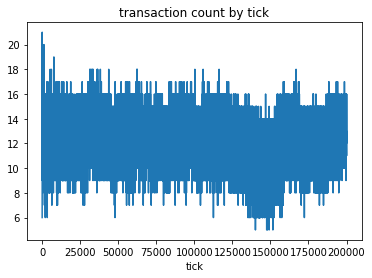

In [10]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

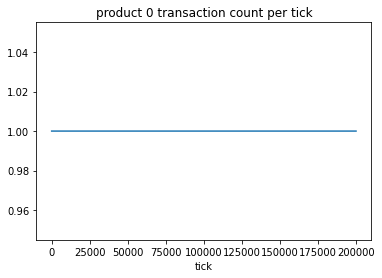

In [11]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

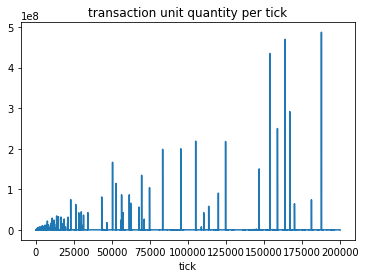

In [12]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

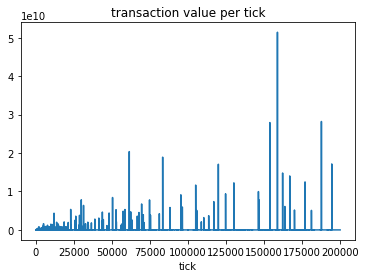

In [13]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

<AxesSubplot:xlabel='tick'>

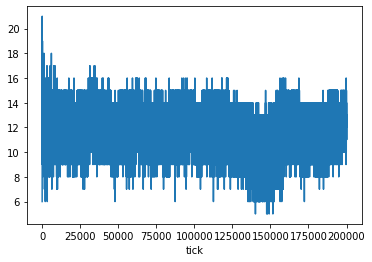

In [14]:
transaction_df.groupby("tick")["product"].nunique().plot()

<AxesSubplot:xlabel='tick'>

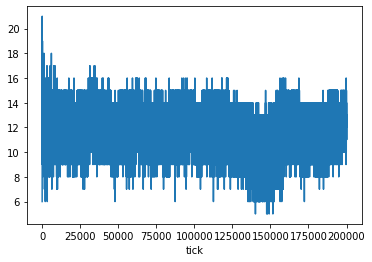

In [15]:
transaction_df.groupby("tick")["seller"].nunique().plot()

<AxesSubplot:xlabel='tick'>

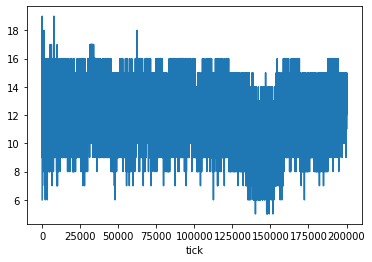

In [16]:
transaction_df.groupby("tick")["buyer"].nunique().plot()

In [17]:
transaction_df["seller"].nunique()

26

In [18]:
transaction_df["buyer"].nunique()

23

In [19]:
transaction_df["product"].nunique()

26

<AxesSubplot:>

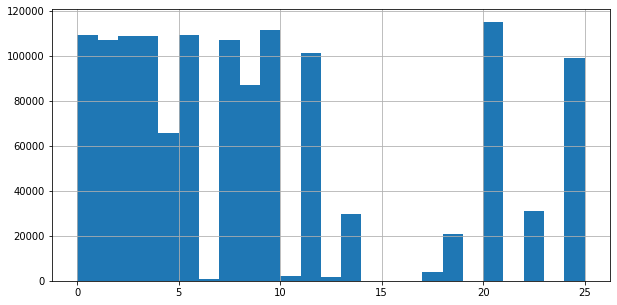

In [20]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].max())

<AxesSubplot:xlabel='tick'>

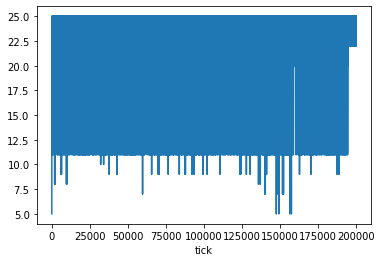

In [21]:
transaction_df.groupby("tick")["product"].max().plot()

In [22]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    108878.000000
mean         16.260396
std           0.708395
min          14.041083
25%          15.750960
50%          16.347776
75%          16.861980
max          17.311918
Name: price, dtype: float64

<AxesSubplot:>

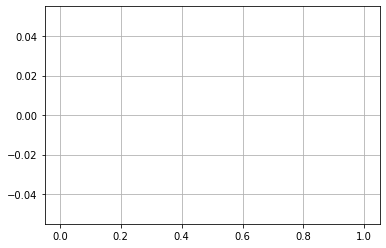

In [23]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

## Transaction Graph

In [24]:
G = nx.from_pandas_edgelist(transaction_df, source="seller", target="buyer", create_using=nx.DiGraph)

In [25]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [26]:
G = nx.relabel_nodes(G, labels)

In [27]:
nx.is_directed_acyclic_graph(G)

True

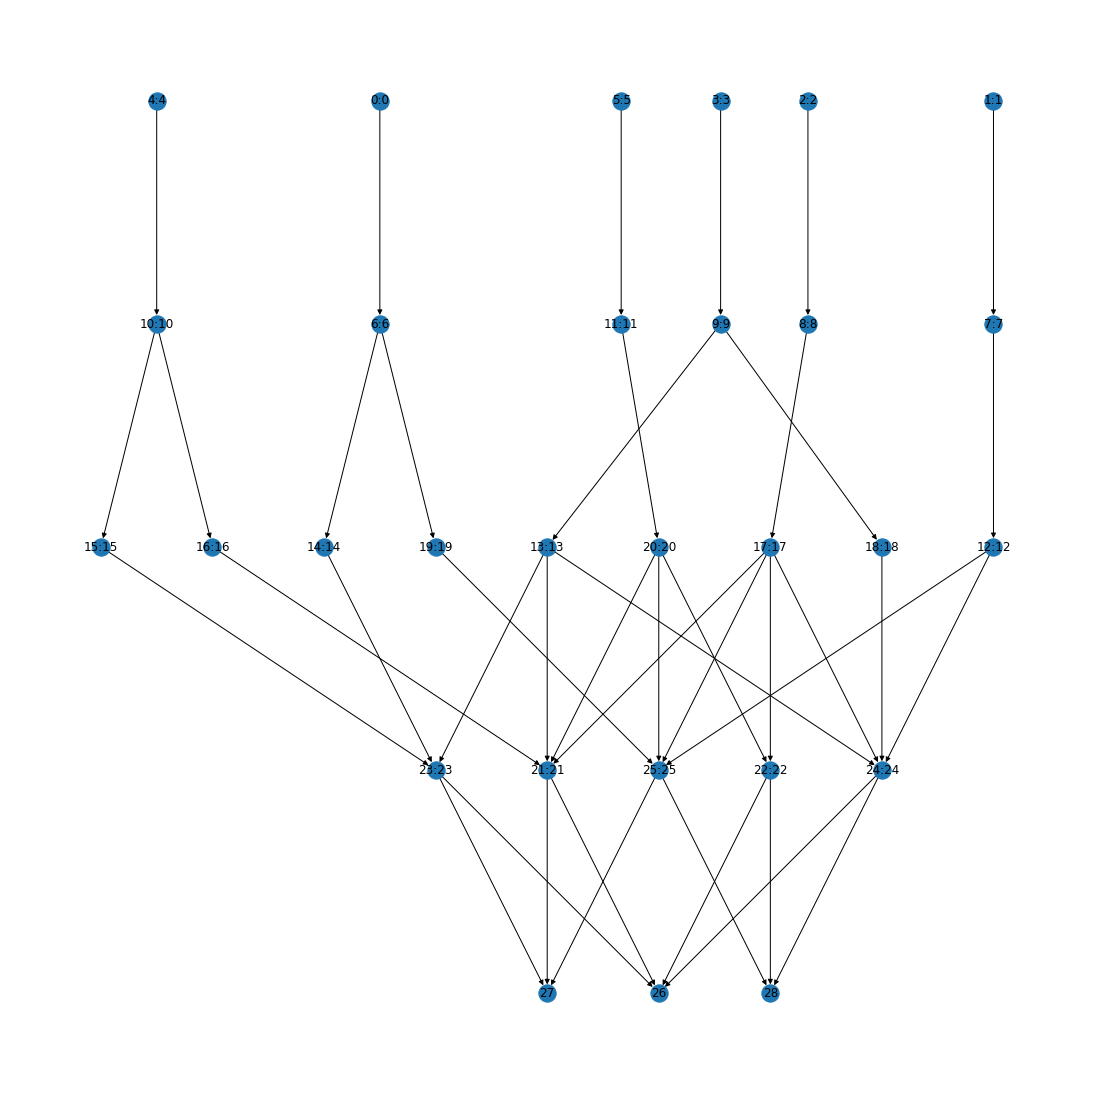

In [28]:
plt.figure(figsize=(15, 15))
#nx.draw_kamada_kawai(G, arrows=True)
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
plt.show()

# Balance

In [29]:
balance_df = econ_sim.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [30]:
balance_df

,agent,tick,balance
0,0,0,8.871081e+02
1,1,0,1.911248e+02
2,2,0,2.000761e+02
3,3,0,1.009825e+03
4,4,0,1.901720e+03
...,...,...,...
5799995,24,199999,5.313579e+01
5799996,25,199999,8.484185e+09
5799997,26,199999,8.037360e+02
5799998,27,199999,2.297470e+03


<AxesSubplot:xlabel='tick'>

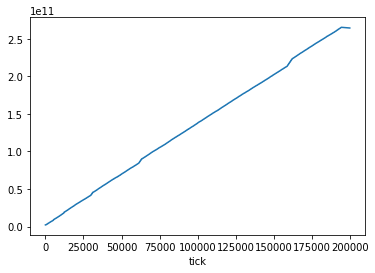

In [31]:
balance_df.groupby("tick")["balance"].sum().plot()

In [32]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    2.900000e+01
mean     7.301216e+07
std      3.675668e+08
min      1.548305e+00
25%      7.468579e+02
50%      8.650000e+03
75%      1.018000e+05
max      1.980445e+09
Name: balance, dtype: float64

In [33]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    2.900000e+01
mean     9.120187e+09
std      1.417268e+10
min      3.291325e+00
25%      8.037360e+02
50%      2.370250e+09
75%      8.484185e+09
max      4.999903e+10
Name: balance, dtype: float64

In [34]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

<BarContainer object of 29 artists>

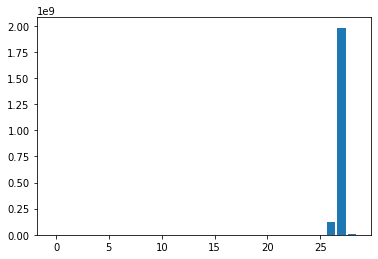

In [35]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])

<BarContainer object of 29 artists>

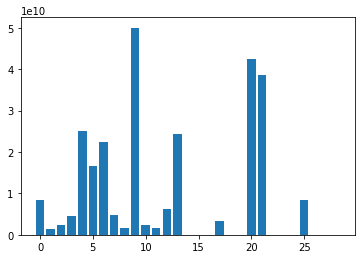

In [36]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])

In [37]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
5799971,0,199999,8.433973e+09
5799972,1,199999,1.403819e+09
5799973,2,199999,2.370250e+09
5799974,3,199999,4.442291e+09
5799975,4,199999,2.501546e+10
5799976,5,199999,1.661669e+10
5799977,6,199999,2.237671e+10
5799978,7,199999,4.671128e+09
5799979,8,199999,1.656586e+09
5799980,9,199999,4.999903e+10


<AxesSubplot:>

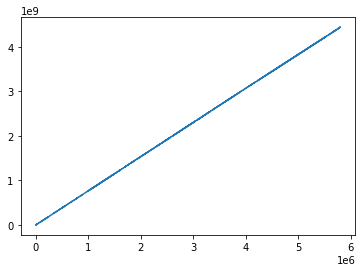

In [38]:
balance_df[balance_df["agent"] == 3]["balance"].plot()

# Inventory

In [39]:
columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
inventory_df = econ_sim.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [40]:
production_chain_df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
production_chain_df.iloc[:,-1][production_chain_df.iloc[:,-1] > 0]

22    25.0
24     7.0
25    10.0
Name: 28, dtype: float64

In [42]:
last_item_inputs = production_chain_df.iloc[:,-1][production_chain_df.iloc[:,-1] > 0].index

In [43]:
lti_df = inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

In [44]:
lti_df[lti_df["agent"].isin([production_chain_df.shape[0]-1])][map(lambda x: str(x), last_item_inputs)]

,22,24,25
5799999,13.0,17.0,73.0


In [45]:
ltb_df[ltb_df["agent"].isin([production_chain_df.shape[0]-1])]

,agent,tick,balance
5799999,28,199999,215633.757051


In [46]:
production_chain_df.iloc[:,last_item_inputs[2]][production_chain_df.iloc[:,last_item_inputs[2]] > 0]

12    7.0
17    8.0
19    6.0
20    5.0
Name: 25, dtype: float64

In [47]:
lii_inputs = production_chain_df.iloc[:,last_item_inputs[2]][production_chain_df.iloc[:,last_item_inputs[2]] > 0].index

In [48]:
lti_df[lti_df["agent"].isin([last_item_inputs[2]])][map(lambda x: str(x), lii_inputs)]

,12,17,19,20
5799996,44218029.0,234302724.0,8403458.0,0.0


In [49]:
ltb_df[ltb_df["agent"].isin([last_item_inputs[2]])]

,agent,tick,balance
5799996,25,199999,8.484185e+09


In [50]:
transaction_df[transaction_df["buyer"] == 21].groupby("product")["amount"].sum()

product
13    133309551.0
16     54179569.0
17     42688683.0
20     92963652.0
Name: amount, dtype: float64

In [51]:
transaction_df[transaction_df["seller"] == 21].groupby("product")["amount"].sum()

product
21    9860904.0
Name: amount, dtype: float64

In [52]:
transaction_df[transaction_df["buyer"] == 21]

,tick,seller,buyer,product,amount,price,value
20,4,16,21,16,15.0,274.169612,4112.544174
72,8,17,21,17,35.0,37.355353,1307.437349
83,10,13,21,13,19.0,585.057930,11116.100666
84,10,20,21,20,14.0,158.966158,2225.526210
101,11,20,21,20,19.0,331.428752,6297.146279
...,...,...,...,...,...,...,...
1322092,199985,20,21,20,2222.0,369.429914,820873.268416
1322133,199990,20,21,20,1111.0,287.879708,319834.355362
1322157,199994,20,21,20,2222.0,386.774465,859412.861353
1322170,199996,20,21,20,2222.0,370.164892,822506.390254


In [53]:
transaction_df[transaction_df["product"] == 8].groupby("buyer")["amount"].sum()

buyer
17    1.999592e+09
Name: amount, dtype: float64

In [54]:
liii_inputs = production_chain_df.iloc[:,lii_inputs[1]][production_chain_df.iloc[:,lii_inputs[1]] > 0].index
lti_df[lti_df["agent"].isin([lii_inputs[1]])][map(lambda x: str(x), liii_inputs)]

,8
5799988,0.0


In [55]:
ltb_df[ltb_df["agent"].isin([lii_inputs[1]])]

,agent,tick,balance
5799988,17,199999,3.376071e+09


In [56]:
ltb_df[ltb_df["agent"].isin([17])]

,agent,tick,balance
5799988,17,199999,3.376071e+09


In [57]:
inventory_df[(inventory_df["tick"] == inventory_df["tick"].max())&(inventory_df["6"]>0)].T

,5799977,5799985,5799990
agent,6.0,14.0,19.0
tick,199999.0,199999.0,199999.0
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,373769736.0,2.0,1.0
7,0.0,0.0,0.0


<AxesSubplot:>

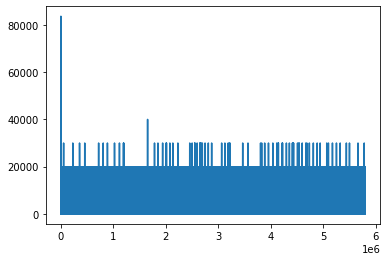

In [58]:
inventory_df[inventory_df["agent"]==1]["1"].plot()

In [59]:
inventory_df[(inventory_df["agent"]==1)&(inventory_df["1"]>10000)]

,agent,tick,0,1,2,3,4,5,6,7,...,19,20,21,22,23,24,25,26,27,28
900,1,31,0.0,19384.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929,1,32,0.0,29384.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
958,1,33,0.0,39383.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
987,1,34,0.0,39811.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016,1,35,0.0,39811.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790721,1,199680,0.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5793650,1,199781,0.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5794984,1,199827,0.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5795593,1,199848,0.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

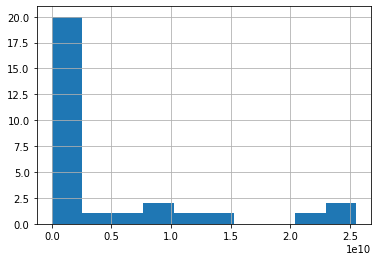

In [60]:
balance_df[balance_df["tick"] == 99999]["balance"].hist()

In [61]:
last_tick_inventory = inventory_df[inventory_df["tick"] == 99999]

In [62]:
balance_df[(balance_df["tick"] == 99999) & (balance_df["agent"] == 18)]

,agent,tick,balance
2899989,18,99999,23.564826


In [63]:
production_chain_df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Profit Analysis

In [64]:
revenue = transaction_df.groupby("seller")["value"].sum()
costs = transaction_df.groupby("buyer")["value"].sum()

In [65]:
costs

buyer
6     1.617172e+10
7     3.740604e+09
8     5.820192e+09
9     3.251548e+10
10    5.132019e+10
11    2.738466e+10
12    8.411731e+09
13    7.487344e+10
14    1.013482e+10
15    4.103215e+10
16    1.272586e+10
17    7.476779e+09
18    7.641065e+09
19    2.841361e+10
20    2.900909e+10
21    1.189841e+11
22    1.080501e+10
23    6.301996e+10
24    2.080175e+10
25    8.250910e+10
26    3.657226e+08
27    3.005127e+11
28    4.227434e+10
Name: value, dtype: float64

In [66]:
revenue

seller
0     1.617172e+10
1     3.740604e+09
2     5.820192e+09
3     3.251548e+10
4     5.132019e+10
5     2.738466e+10
6     3.854843e+10
7     8.411731e+09
8     7.476779e+09
9     8.251451e+10
10    5.375801e+10
11    2.900909e+10
12    1.471526e+10
13    9.909454e+10
14    1.013481e+10
15    4.103211e+10
16    1.272585e+10
17    1.085285e+10
18    7.641049e+09
19    2.841360e+10
20    7.150987e+10
21    1.575341e+11
22    1.080534e+10
23    6.301933e+10
24    2.080097e+10
25    9.099303e+10
Name: value, dtype: float64

In [70]:
revenue-costs

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6     2.237671e+10
7     4.671127e+09
8     1.656586e+09
9     4.999903e+10
10    2.437819e+09
11    1.624421e+09
12    6.303532e+09
13    2.422109e+10
14   -8.646709e+03
15   -4.104507e+04
16   -1.363176e+04
17    3.376070e+09
18   -1.577375e+04
19   -1.174300e+04
20    4.250078e+10
21    3.855003e+10
22    3.211348e+05
23   -6.265320e+05
24   -7.807469e+05
25    8.483929e+09
26             NaN
27             NaN
28             NaN
Name: value, dtype: float64

In [67]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]

,agent,tick,balance
5799971,0,199999,8.433973e+09
5799972,1,199999,1.403819e+09
5799973,2,199999,2.370250e+09
5799974,3,199999,4.442291e+09
5799975,4,199999,2.501546e+10
5799976,5,199999,1.661669e+10
5799977,6,199999,2.237671e+10
5799978,7,199999,4.671128e+09
5799979,8,199999,1.656586e+09
5799980,9,199999,4.999903e+10


In [68]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,19,20,21,22,23,24,25,26,27,28
5799971,0,199999,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799972,1,199999,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799973,2,199999,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799974,3,199999,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799975,4,199999,0.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799976,5,199999,0.0,0.0,0.0,0.0,0.0,10000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799977,6,199999,0.0,0.0,0.0,0.0,0.0,0.0,373769736.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799978,7,199999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799979,8,199999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799980,9,199999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
production_chain_df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
